# StepCountJITAI quickstart

# <a href="https://colab.research.google.com/github/reml-lab/StepCountJITAI/blob/main/examples/StepCountJITAI_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an official notebook for the paper **StepCountJITAI: simulation environment for RL with application to physical activity adaptive intervention**, accepted at NeurIPS 2024 workshop on Behavioral ML.

**Paper and poster links**:
+ [arXiv link](https://arxiv.org/abs/2411.00336)
+ [paper link](https://openreview.net/forum?id=zEFQfGiUWz)
+ [poster](https://github.com/reml-lab/StepCountJITAI/tree/main/StepCountJITAI_poster.pdf)

**Paper abstract**:
The use of reinforcement learning (RL) to learn policies for just-in-time adaptive interventions
(JITAIs) is of significant interest in many behavioral intervention domains including improving levels
of physical activity. In a messaging-based physical activity JITAI, a mobile health app is typically
used to send messages to a participant to encourage engagement in physical activity. In this setting,
RL methods can be used to learn what intervention options to provide to a participant in different
contexts. However, deploying RL methods in real physical activity adaptive interventions comes with
challenges: the cost and time constraints of real intervention studies result in limited data to learn
adaptive intervention policies. Further, commonly used RL simulation environments have dynamics
that are of limited relevance to physical activity adaptive interventions and thus shed little light on
what RL methods may be optimal for this challenging application domain. In this paper, we introduce
StepCountJITAI, an RL environment designed to foster research on RL methods that address the
significant challenges of policy learning for adaptive behavioral interventions.

**This notebook**: we describe how to use the StepCountJITAI simulation environment.


#  Initialize code

In [7]:
!pip install gymnasium
# Below is the official pip install for StepCountJITAI.
!pip install StepCountJITAI
# Below is for the RL agents.
!pip install rljitai

In [2]:
from StepCountJITAI.envs import StepCountJITAI
from rl_jitai_simulation.agents import ReinforceAgent, DQNAgent
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

# 1. Introduction

We describe how to use the StepCountJITAI simulation environment.

## 1.1 How to use the StepCountJITAI simulation environment

+ StepCountJITAI env produces various observations variables (obs). The possible obs names are: ```'C', 'P', 'L', 'H', 'D', 'T'```. These can be set using ```chosen_obs_names```, for example: ```chosen_obs_names=['C','H','D']```, ```['L','H','D']``` or ```['P','T']```, etc., where C is for true contex, P is for probability of context=1, L is for inferred context, H is for habituation level, D is for disengagement risk and T is the binary indicator.

+ There are 4 possible actions (action values are: ```0,1,2,3```).

+ StepCountJITAI env default parameters are: habituation decay ```δh=0.1```, habituation increment  ```εh=0.05```, disengagement decay ```δd=0.1```, disengagement increment ```εd=0.1```, base reward (for $a_t=1$) ```ρ1=50```, base reward (for $a_t=c_t+2$) ```ρ2=200```. The context uncertainty ```sigma``` values are: ```0, 0.4,..., 2```.

+ StepCountJITAI env default version is deterministic (```n_version=0```). To use the stochastic version with Uniform distribution, set ```n_version=1, b_using_uniform=True```.  To use the stochastic version with Beta distribution, set ```n_version=1, b_using_uniform=False```. The equations for the behavioral dynamics are described in the paper.

+ StepCountJITAI env is built on top of the standard API for RL (i.e., Gymnasium), and can be plugged in as an environment in an RL loop.

## 1.2 Quickstart: how to use StepCountJITAI env, in a simple loop, with random actions

It is very easy to use the StepCountJITAI env to simulate trajectories, for example: ```env.get_C()``` is used to get the current value for the true context ```C```.

env config: obs=C-P-L-H-D-T, σ=0.4, δh=0.1, εh=0.05, δd=0.1, εd=0.4, µs=[0.1, 0.1], ρ1=50.0, ρ2=200.0, ρ3=0, D_threshold=1, n_version=1, seed=0, a=0.01, σs=10.0


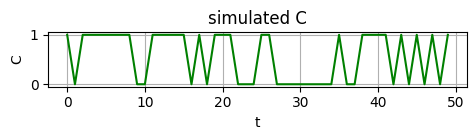

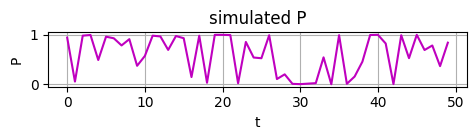

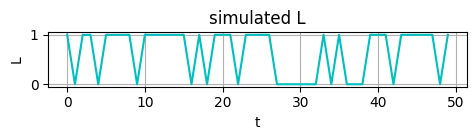

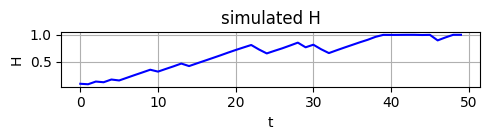

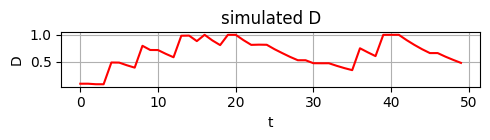

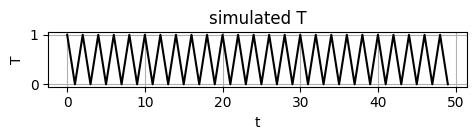

In [3]:
# Example: using stochastic version with Uniform distribution
env = StepCountJITAI(sigma=0.4, chosen_obs_names=['C', 'P', 'L', 'H', 'D', 'T'],
                     n_version=1, b_using_uniform=True, chosen_a=0.01, σs=10.,
                     δh=0.1, εh=0.05, δd=0.1, εd=0.4, µs=[0.1,0.1], ρ1=50., ρ2=200., ρ3=0, D_threshold=1)

Cs=[]; Ps=[]; Ls=[]; Hs=[]; Ds=[]; Ts=[]
for time_step in range(50):
  action = np.random.choice(4)
  obs_, reward, done, _, info = env.step(action)
  current_state = env.get_current_state()
  Cs.append(env.get_C())
  Ps.append(env.get_P())
  Ls.append(env.get_L())
  Hs.append(env.get_H())
  Ds.append(env.get_D())
  Ts.append(env.get_T())

def plot_update(title):
  plt.title('simulated '+title)
  plt.xlabel('t'); plt.ylabel(title); plt.tight_layout(); plt.grid(); plt.show()
plt.figure(figsize=(5,1.5)); plt.plot(Cs, color='g'); plot_update('C')
plt.figure(figsize=(5,1.5)); plt.plot(Ps, color='m'); plot_update('P')
plt.figure(figsize=(5,1.5)); plt.plot(Ls, color='c'); plot_update('L')
plt.figure(figsize=(5,1.5)); plt.plot(Hs, color='b'); plot_update('H')
plt.figure(figsize=(5,1.5)); plt.plot(Ds, color='r'); plot_update('D')
plt.figure(figsize=(5,1.5)); plt.plot(Ts, color='k'); plot_update('T')

## 1.3 Quickstart: how to use StepCountJITAI env, in an RL loop

It is very easy to use the StepCountJITAI env:
1. Instantiate the StepCountJITAI env, with desired sigma (sigma is the context uncertainty as described in the paper)
2. Call env.reset()
3. Call env.step(action) in a loop

### 1.3.1 Code to run RL loop for DQN and REINFORCE

In [4]:
def run_RL_loop_DQN(env, agent, n_episodes, b_train, b_plot=False, plot_title='', y_lim=(-200,3500)):
  return_values = []
  for i in tqdm(range(n_episodes), desc ="DQN {} σ={} duration".format(env.chosen_obs_names_str, env.sigma)):
    obs, _ = env.reset()
    return_value = 0
    done = False
    while not done:
      action = agent.choose_action(obs)
      obs_, reward, done, _, info = env.step(action)
      agent.observe(obs, action, reward, obs_, done)
      if b_train: agent.update()
      obs = obs_
      return_value += reward
    return_values.append(return_value)
  if b_plot:
    plt.figure(figsize=(3,2))
    plt.plot(return_values)
    if len(plot_title) < 1:
      plot_title = ' (σ={})'.format(env.sigma)
    plt.title('DQN {} learning{}'.format(env.chosen_obs_names_str, plot_title))
    plt.ylim(y_lim); plt.xlabel('episode'); plt.ylabel('return'); plt.grid(); plt.show()
  return return_values

def run_RL_loop_REINFORCE(env, agent, M, n_episodes, b_train, b_plot=False, plot_title='', y_lim=(-200,3500)):
  return_values = []
  for i in tqdm(range(n_episodes), desc ="REINFORCE {} σ={} duration".format(env.chosen_obs_names_str, env.sigma)):
    if b_train: agent.init_grad()
    return_samples = []
    for m in range(M):
      obs, _ = env.reset()
      return_sample = 0
      done = False
      while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, _, info = env.step(action)
        agent.store_rewards(reward)
        obs = obs_
        return_sample += reward
      return_samples.append(return_sample)
      if b_train: agent.compute_grad()
    if b_train: agent.take_step(env.max_episode_length)
    return_values.append(np.mean(return_samples))
  if b_plot:
    plt.figure(figsize=(3,2))
    plt.plot(return_values)
    if len(plot_title) < 1:
      plot_title = ' (σ={})'.format(env.sigma)
    plt.title('REINFORCE {} learning{}'.format(env.chosen_obs_names_str, plot_title))
    plt.ylim(y_lim); plt.xlabel('episode'); plt.ylabel('return'); plt.grid(); plt.show()
  return return_values

def set_random_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)

def  get_key(sigma, δd, εd, seed, chosen_obs_name):
  str_detail = 'σ={} δd={} εd={} seed={} obs={}'.format(sigma, δd, εd, seed, '-'.join(chosen_obs_name))
  str_key = str_detail.replace('.','').replace(' ','_').replace('-','').replace('=','')
  return str_key

### 1.3.2 Quickstart: how to use StepCountJITAI env, in an RL loop, using DQN (dueling DQN)

env config: obs=C-H-D, σ=0.4, δh=0.1, εh=0.05, δd=0.1, εd=0.4, µs=[0.1, 0.1], ρ1=50.0, ρ2=200.0, ρ3=0.0, D_threshold=0.99, n_version=1, seed=0, a=0.01, σs=10.0


DQN C-H-D σ=0.4 duration: 100%|██████████| 250/250 [00:52<00:00,  4.80it/s]


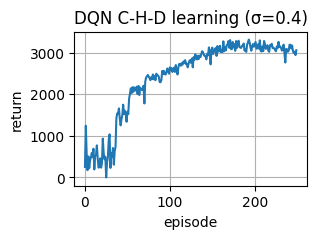

In [5]:
set_random_seed(0)
env = StepCountJITAI(sigma=0.4, chosen_obs_names=['C', 'H', 'D'], n_version=1, b_using_uniform=True, chosen_a=0.01, σs=10.)
agent = DQNAgent(gamma=1, lr=5e-4, batch_size=64, input_dims=[env.get_obs_length()], n_actions=4, fc1_dim=128, fc2_dim=128)
return_values = run_RL_loop_DQN(env, agent, n_episodes=250, b_train=True, b_plot=True)

### 1.3.3 Quickstart: how to use StepCountJITAI env, in an RL loop, using REINFORCE

env config: obs=C-H-D, σ=0.4, δh=0.1, εh=0.05, δd=0.1, εd=0.4, µs=[0.1, 0.1], ρ1=50.0, ρ2=200.0, ρ3=0.0, D_threshold=0.99, n_version=1, seed=0, a=0.01, σs=10.0


REINFORCE C-H-D σ=0.4 duration: 100%|██████████| 5000/5000 [17:47<00:00,  4.68it/s]


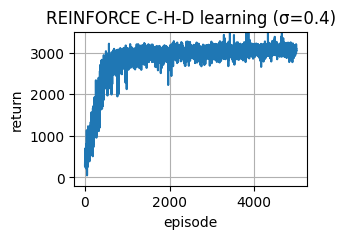

In [6]:
set_random_seed(0)
env = StepCountJITAI(sigma=0.4, chosen_obs_names=['C', 'H', 'D'], n_version=1, b_using_uniform=True, chosen_a=0.01, σs=10.)
agent = ReinforceAgent(gamma=1, lr=6e-4, input_dims=[env.get_obs_length()], n_actions=4, fc1_dim=128, fc2_dim=None)
return_values = run_RL_loop_REINFORCE(env, agent, M=3, n_episodes=5000, b_train=True, b_plot=True)

# StepCountJITAI env can be used to develop new RL algorithms for adative intervention.

Please check out these related papers:

+ **BOTS: Batch Bayesian Optimization of Extended Thompson Sampling for Severely Episode-Limited RL Settings**, accepted at NeurIPS 2024 workshop on Bayesian Decision-making and Uncertainty. [arXiv link](https://arxiv.org/pdf/2412.00308)
+ **Assessing the Impact of Context Inference Error and Partial Observability on RL Methods for Just-In-Time Adaptive Interventions**, accepted at UAI 2023. [arXiv link](https://arxiv.org/pdf/2305.09913)